# German_Traffic_Sign_Recognition
## About Dataset
### Context
The [German Traffic Sign Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?datasetId=82373)
 is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

**Acknowledgements** \
INI Benchmark Website


## Imports

In [1]:
import logging
import os

# ignore all the warning and debug information from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from sklearn.metrics import classification_report
from libs.nn.conv.lenet import LeNet
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from pathlib import Path
import os

In [2]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Prepare Dataset for training

In [3]:
# Look into the data directory
images_dir = './gtsrb-german-traffic-sign'

dataset_dir = f'{images_dir}/Train'

In [4]:
BATCH_SIZE = 32
IMG_WIDTH = IMG_HEIGHT = 32
RANDOM_STATE=42

In [5]:
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

In [6]:
len(classes.keys())

43

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  shuffle=True,
  label_mode='categorical' ,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [8]:
val_ds = keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical' ,
  shuffle=True,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  seed=42,
  batch_size=BATCH_SIZE)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [9]:
for x, y in train_ds.take(1):
    print(x)
    print(y)
    break

tf.Tensor(
[[[[ 12.        11.        13.      ]
   [ 12.        11.        14.      ]
   [ 12.        10.        13.      ]
   ...
   [ 12.        11.        14.      ]
   [ 12.        10.        13.      ]
   [ 11.        10.        13.      ]]

  [[ 12.        11.        13.      ]
   [ 11.        10.        13.      ]
   [ 12.        10.        12.      ]
   ...
   [ 11.        10.        13.      ]
   [ 13.        11.        13.      ]
   [ 11.        10.        12.      ]]

  [[ 13.        11.        13.      ]
   [ 13.        11.        13.      ]
   [ 12.        10.        12.      ]
   ...
   [ 10.         9.        11.      ]
   [ 12.        10.        12.      ]
   [ 12.        10.        12.      ]]

  ...

  [[ 13.        11.        13.      ]
   [ 12.        10.        13.      ]
   [ 13.        11.        14.      ]
   ...
   [ 14.        12.        14.      ]
   [ 13.        12.        15.      ]
   [ 13.        11.        15.      ]]

  [[ 12.        10.        12.    

Normalization

In [10]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

labels are already one-hot encoded, now we have to normalize the images, that will be done in side the model (1st Sequential layer)

## Prepare CNN Model

Setting up the callbacks

In [11]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
                                                     
SAVED_MODEL_PATH = 'model/ge_traffic_sign_recognition.h5'
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(SAVED_MODEL_PATH, 
                                                      monitor="val_loss", 
                                                      mode="min",
                                                      save_best_only=True, 
                                                      verbose=1)

run_index = 1 # increment every time you train the model
run_logdir = Path() / "ge_traffic_sign_recog" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [12]:
model = LeNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth= 3, classes=len(classes.keys()))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 20)        1520      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 50)        25050     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 50)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0

In [13]:
EPOCHS = 100
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=0.01/EPOCHS, momentum=0.9, nesterov=True)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Configure the dataset for performance

In [14]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train the Model

In [15]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(42)

In [16]:
history = model.fit(train_ds,
                        validation_data=val_ds,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks)

Epoch 1/100
981/981 [==============================] - ETA: 0s - loss: 0.9438 - accuracy: 0.7409
Epoch 1: val_loss improved from inf to 0.22651, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 4s 3ms/step - loss: 0.9438 - accuracy: 0.7409 - val_loss: 0.2265 - val_accuracy: 0.9339
Epoch 2/100
966/981 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9741
Epoch 2: val_loss improved from 0.22651 to 0.07547, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 2s 2ms/step - loss: 0.0964 - accuracy: 0.9744 - val_loss: 0.0755 - val_accuracy: 0.9833
Epoch 3/100
975/981 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9889
Epoch 3: val_loss improved from 0.07547 to 0.05830, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 2s 2ms/step - loss: 0.0426 - accuracy: 0.9889 - val_loss: 0.0583 - val_accuracy: 0.9874
Epoch

## Evaluate the Model

In [17]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

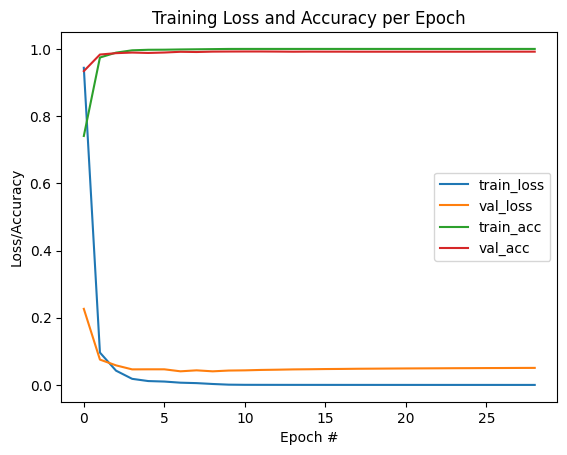

In [18]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy per Epoch")

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [19]:
loss, accuracy = model.evaluate(val_ds)
loss, accuracy

246/246 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy: 0.9920


(0.04057149589061737, 0.9919652938842773)

In [25]:
predicted = model.predict(val_ds)
for pred in predicted[:3]:
    print(np.argmax(pred, axis=-1))

246/246 [==============================] - 0s 954us/step
24
9
41


In [21]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  actual =np.argmax(actual, axis=1) # because one hot encoded 
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [22]:
actual, predicted = get_actual_predicted_labels(val_ds)
actual[:10], predicted[:10].numpy()

246/246 [==============================] - 0s 833us/step


(array([ 5, 15, 40, 40,  7,  1, 18,  9, 27,  9]),
 array([42, 41, 42, 27, 27, 19, 33,  3, 18, 19]))

In [23]:
print(classification_report(actual, predicted,
                            target_names=classes.values()))

                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.00      0.00      0.00        44
         Speed limit (30km/h)       0.05      0.05      0.05       448
         Speed limit (50km/h)       0.04      0.04      0.04       390
         Speed limit (60km/h)       0.03      0.03      0.03       297
         Speed limit (70km/h)       0.06      0.06      0.06       396
         Speed limit (80km/h)       0.07      0.07      0.07       441
  End of speed limit (80km/h)       0.01      0.01      0.01       173
        Speed limit (100km/h)       0.02      0.02      0.02       146
        Speed limit (120km/h)       0.01      0.01      0.01        82
                   No passing       0.02      0.02      0.02       206
 No passing veh over 3.5 tons       0.04      0.04      0.04       248
 Right-of-way at intersection       0.00      0.00      0.00        46
                Priority road       0.06      0.06      0.06       429
     